In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

In [2]:
#get data
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

life_exp_df = pd.read_sql_query('select * from lifeexpectancy',con=engine)

engine.dispose()

In [3]:
#look at the first few rows of data
life_exp_df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [4]:
#get variable types
life_exp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
percentage expenditure             2938 non-null float64
Hepatitis B                        2385 non-null float64
Measles                            2938 non-null int64
 BMI                               2904 non-null float64
under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Total expenditure                  2712 non-null float64
Diphtheria                         2919 non-null float64
 HIV/AIDS                          2938 non-null

In this data set, we have 22 variables. The majority of them are numeric, with only 2 (Country and Status) string object-type variables. Next, we will check for missing values.

In [5]:
#check for missing values
life_exp_df.isnull().sum()*100/life_exp_df.isnull().count()

Country                             0.000000
Year                                0.000000
Status                              0.000000
Life expectancy                     0.340368
Adult Mortality                     0.340368
infant deaths                       0.000000
Alcohol                             6.603131
percentage expenditure              0.000000
Hepatitis B                        18.822328
Measles                             0.000000
 BMI                                1.157250
under-five deaths                   0.000000
Polio                               0.646698
Total expenditure                   7.692308
Diphtheria                          0.646698
 HIV/AIDS                           0.000000
GDP                                15.248468
Population                         22.191967
 thinness  1-19 years               1.157250
 thinness 5-9 years                 1.157250
Income composition of resources     5.684139
Schooling                           5.547992
dtype: flo

Many of the variables are not missing any values, and the majority of the variables are missing less than 10 percent of the data. Three variables Hepatitis B, GDP and Population are missing a more significant portion of the data, 15-23%. We will replace all of the missing values by interpolation.

In [6]:
#fill missing values by interpolation
cols = ['Life expectancy ', 'Adult Mortality', 'Alcohol', 'Hepatitis B', ' BMI ', 'Polio', 'Total expenditure',
       'Diphtheria ', 'GDP', 'Population', ' thinness  1-19 years', ' thinness 5-9 years', 
        'Income composition of resources', 'Schooling'] 

for col in cols:
        life_exp_df.loc[:, col] = life_exp_df.loc[:, col].interpolate()   

After addressing missing values, we will now look to address outliers in the data. To start, I will look at the summary of the data to see whether the ranges of the variables fall within expected values. For example, for the Hepatitis B vaccine variable, which is a percentage, should only take values between 0 and 100.

In [7]:
#summarize the data
life_exp_df.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.00000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2.938000e+03,2938.000000,2938.000000,2938.000000,2938.000000
mean,2007.518720,69.214874,164.744554,30.303948,4.548919,738.251295,78.536419,2419.592240,38.29869,42.035739,82.474643,5.940955,82.246086,1.742103,7432.027910,1.229209e+07,4.882301,4.920439,0.634458,12.076804
std,4.613841,9.510819,124.226596,117.926501,3.994854,1987.914858,25.177963,11467.272489,19.99140,160.445548,23.420689,2.445751,23.705664,5.077785,13410.150286,5.471908e+07,4.433359,4.532488,0.209574,3.342316
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.00000,0.000000,3.000000,0.370000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.100000,74.000000,0.000000,0.902500,4.685343,71.000000,0.000000,19.32500,0.000000,78.000000,4.312500,78.000000,0.100000,553.618620,2.536025e+05,1.600000,1.600000,0.500000,10.200000
50%,2008.000000,72.000000,144.000000,3.000000,3.697500,64.912906,89.000000,17.000000,43.25000,4.000000,93.000000,5.760000,93.000000,0.100000,2192.681084,1.576319e+06,3.400000,3.400000,0.684000,12.400000
75%,2012.000000,75.600000,228.000000,22.000000,7.550000,441.534144,96.000000,360.250000,56.10000,28.000000,97.000000,7.440000,97.000000,0.800000,7183.381694,8.215738e+06,7.200000,7.300000,0.791107,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.30000,2500.000000,99.000000,17.600000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


Based on the summary above, there are four variables that take values that seem to be outliers or nonsense values: infant deaths, percentage expenditure, measles, and under-five deaths. The values for infant deaths, measles, and under-five deaths are all per 1000 population, so we would expect the maximum for those variables to be around 1000. Percentage expenditure is the expenditure on health as a percentage of GDP per capita, so while it could take values over 100 percent, values like 19,479 seem extreme. Next, I will visualize and address these values.

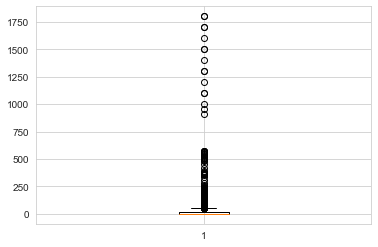

In [8]:
#plot distribution of infant deaths
plt.boxplot(life_exp_df['infant deaths'])
plt.show()

From the boxplot above, it is clear that there are some extreme values for infant deaths, so I will now winsorize the variable and visualize the winsorozed variable.

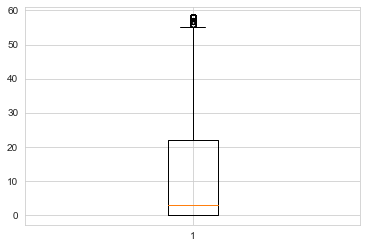

In [9]:
#winsorize infant deaths
life_exp_df['winsorized_infant_deaths'] = winsorize(life_exp_df['infant deaths'], (0, 0.10))

#plot winsorized variable
plt.boxplot(life_exp_df['winsorized_infant_deaths'])
plt.show()

While our new variable still has a few data points outside the main boxplot area, the extreme outliers have been removed. Next, I will look at the percentage expenditure variable in a similar manner.

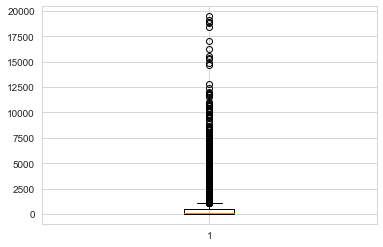

In [10]:
#plot percentage expenditure
plt.boxplot(life_exp_df['percentage expenditure'])
plt.show()

The majority of the data is concentrated close to 0, but there are a large number of data points with extreme values. Again, we will winsorize the top 10% of our data.

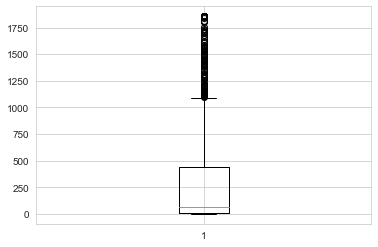

In [11]:
#winsorize percentage expenditure
life_exp_df['winsorized_percentage_expenditure'] = winsorize(life_exp_df['percentage expenditure'], (0, 0.10))

#plot winsorized variable
plt.boxplot(life_exp_df['winsorized_percentage_expenditure'])
plt.show()

This variable still has some outliers, but without knowing the cause of those outliers, I will not remove them. Next, I will look at the measles variable.

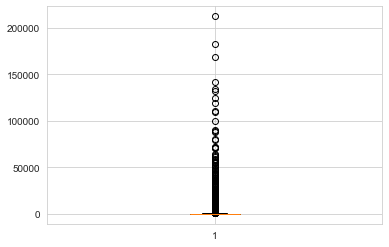

In [12]:
#plot measles
plt.boxplot(life_exp_df['Measles '])
plt.show()

There are clearly a lot of extreme values for this variable. Since this variable is described as the number of measles cases reported per 1000 population and you can only get measles once, we would not expect this value to be over 1000. It appears that there may be an issue with data collection of this variable.

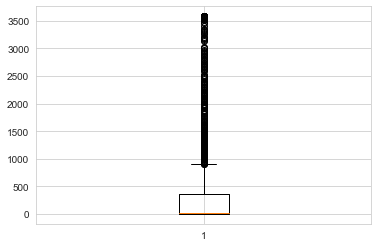

In [13]:
#winsorize variable
life_exp_df['winsorized_measles'] = winsorize(life_exp_df['Measles '], (0, 0.10))

#plot winsorized data
plt.boxplot(life_exp_df['winsorized_measles'])
plt.show()

This winsorized variable contains a large number of values greater than 1000, the largest value that we would expect, so we will instead winsorize 15% of the upper end of our data.

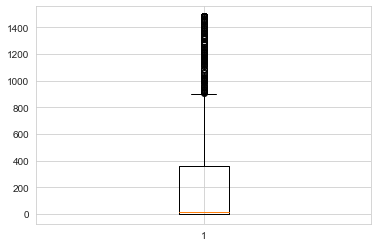

In [14]:
#winsorize variable
life_exp_df['winsorized_measles'] = winsorize(life_exp_df['Measles '], (0, 0.15))

#plot winsorized data
plt.boxplot(life_exp_df['winsorized_measles'])
plt.show()

The majority of outliers in our data have now been winsorized. Finally, we will look at under-five deaths.

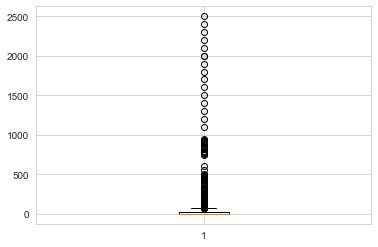

In [15]:
#plot under-five deaths
plt.boxplot(life_exp_df['under-five deaths '])
plt.show()

Similarly to above, we will winsorized 10% of the upper end of our data.

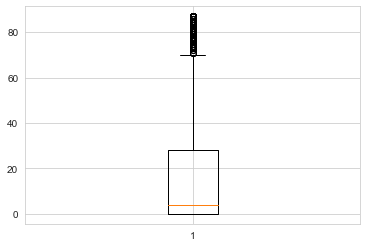

In [16]:
#winsorize under-five deaths
life_exp_df['winsorized_under-five_deaths'] = winsorize(life_exp_df['under-five deaths '], (0, 0.10))

#plot winsorized variable
plt.boxplot(life_exp_df['winsorized_under-five_deaths'])
plt.show()

Now that we have addressed missing values and outliers, we will move on to exploring our data. First, I will plot a histogram of our variable of interest, life expectancy.

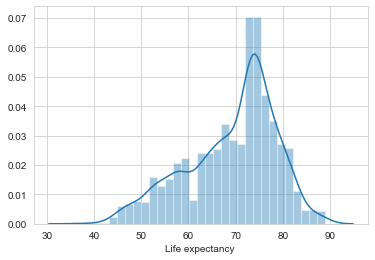

In [17]:
sns.distplot(life_exp_df['Life expectancy '])
plt.show()

The majority of values for life expectancy fall between 70 and 80 with a few values over 80 and a number of values below 70. Next, we will look at the factors that affect life expectancy. First, we will look at the relationship between life expectancy and the categorical variables in our data. While there are too many countries to easily visualize in a chart, we can look at the relationship between status and life expectancy visually.

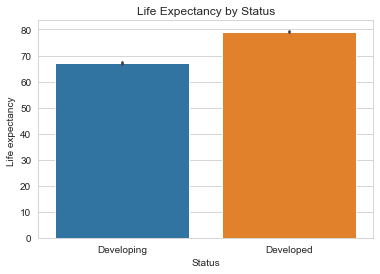

In [18]:
#plot life expectancy by status
sns.barplot(life_exp_df['Status'], life_exp_df['Life expectancy '])
plt.title('Life Expectancy by Status')
plt.show()

From the chart above, we can see that there is a significant difference between the life expectancy in developing countries and the life expectancy in developed countries. This difference means that Status would be a good variable to incorporate into a potential model. 

Now, we will look more closely at the correlation between the numerical variables and life expectancy.

In [19]:
#get correlation between variables
life_exp_df.corr()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,...,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,winsorized_infant_deaths,winsorized_percentage_expenditure,winsorized_measles,winsorized_under-five_deaths
Year,1.000000,0.168309,-0.079264,-0.037415,-0.064487,0.031400,0.145777,-0.082493,0.100417,-0.042937,...,0.089699,0.019915,-0.038570,-0.040661,0.223818,0.185780,-0.048067,0.023991,-0.133978,-0.053827
Life expectancy,0.168309,1.000000,-0.695730,-0.196197,0.400068,0.382069,0.247419,-0.157298,0.556433,-0.222151,...,0.435854,-0.007126,-0.476809,-0.472485,0.690071,0.703409,-0.560574,0.482369,-0.324302,-0.588655
Adult Mortality,-0.079264,-0.695730,1.000000,0.078762,-0.194070,-0.242587,-0.162578,0.031226,-0.383224,0.094134,...,-0.283332,-0.025440,0.307734,0.314769,-0.440536,-0.430481,0.361392,-0.311380,0.189709,0.378708
infant deaths,-0.037415,-0.196197,0.078762,1.000000,-0.114836,-0.085612,-0.200825,0.501128,-0.226540,0.996629,...,-0.107450,0.538589,0.462953,0.467439,-0.132327,-0.173790,0.476575,-0.131697,0.370034,0.480864
Alcohol,-0.064487,0.400068,-0.194070,-0.114836,1.000000,0.337902,0.092366,-0.050497,0.319618,-0.112036,...,0.342275,-0.029223,-0.420123,-0.408260,0.442169,0.507064,-0.325668,0.392668,-0.187855,-0.321516
percentage expenditure,0.031400,0.382069,-0.242587,-0.085612,0.337902,1.000000,-0.033524,-0.056596,0.228084,-0.087852,...,0.871453,-0.016310,-0.252133,-0.253622,0.359488,0.369717,-0.220311,0.764309,-0.100253,-0.215290
Hepatitis B,0.145777,0.247419,-0.162578,-0.200825,0.092366,-0.033524,1.000000,-0.129531,0.172639,-0.208634,...,0.031839,-0.080645,-0.141744,-0.150593,0.193478,0.201451,-0.222556,0.042649,-0.198912,-0.232254
Measles,-0.082493,-0.157298,0.031226,0.501128,-0.050497,-0.056596,-0.129531,1.000000,-0.175347,0.507809,...,-0.067382,0.229798,0.222427,0.217983,-0.087650,-0.082928,0.353292,-0.091834,0.430585,0.359158
BMI,0.100417,0.556433,-0.383224,-0.226540,0.319618,0.228084,0.172639,-0.175347,1.000000,-0.236850,...,0.271717,-0.060964,-0.533952,-0.540459,0.461457,0.488210,-0.447790,0.309963,-0.320488,-0.466468
under-five deaths,-0.042937,-0.222151,0.094134,0.996629,-0.112036,-0.087852,-0.208634,0.507809,-0.236850,1.000000,...,-0.110803,0.526147,0.465291,0.468655,-0.149759,-0.188784,0.488798,-0.135678,0.377020,0.495406


While there is a lot of information contained in the chart above, it is difficult to read and analyze the relevant information, so I will eliminate some variables from the correlation to make it easier to read. First, I will remove the variables that have been winsorized and leave only the winsorized versions.

In [20]:
vars = ['Life expectancy ', 'Year', 'Adult Mortality', 'Alcohol', 'Hepatitis B', ' BMI ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population', ' thinness  1-19 years', ' thinness 5-9 years', 
        'Income composition of resources', 'Schooling', 'winsorized_infant_deaths', 'winsorized_percentage_expenditure',
       'winsorized_measles', 'winsorized_under-five_deaths']
life_exp_df[vars].corr()

,Life expectancy,Year,Adult Mortality,Alcohol,Hepatitis B,BMI,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,winsorized_infant_deaths,winsorized_percentage_expenditure,winsorized_measles,winsorized_under-five_deaths
Life expectancy,1.000000,0.168309,-0.695730,0.400068,0.247419,0.556433,0.459865,0.210843,0.474084,-0.555929,0.435854,-0.007126,-0.476809,-0.472485,0.690071,0.703409,-0.560574,0.482369,-0.324302,-0.588655
Year,0.168309,1.000000,-0.079264,-0.064487,0.145777,0.100417,0.095580,0.079345,0.135174,-0.139741,0.089699,0.019915,-0.038570,-0.040661,0.223818,0.185780,-0.048067,0.023991,-0.133978,-0.053827
Adult Mortality,-0.695730,-0.079264,1.000000,-0.194070,-0.162578,-0.383224,-0.272553,-0.116293,-0.273311,0.523245,-0.283332,-0.025440,0.307734,0.314769,-0.440536,-0.430481,0.361392,-0.311380,0.189709,0.378708
Alcohol,0.400068,-0.064487,-0.194070,1.000000,0.092366,0.319618,0.222830,0.289631,0.218683,-0.048190,0.342275,-0.029223,-0.420123,-0.408260,0.442169,0.507064,-0.325668,0.392668,-0.187855,-0.321516
Hepatitis B,0.247419,0.145777,-0.162578,0.092366,1.000000,0.172639,0.446056,0.088999,0.532925,-0.117155,0.031839,-0.080645,-0.141744,-0.150593,0.193478,0.201451,-0.222556,0.042649,-0.198912,-0.232254
BMI,0.556433,0.100417,-0.383224,0.319618,0.172639,1.000000,0.282080,0.233848,0.280483,-0.243181,0.271717,-0.060964,-0.533952,-0.540459,0.461457,0.488210,-0.447790,0.309963,-0.320488,-0.466468
Polio,0.459865,0.095580,-0.272553,0.222830,0.446056,0.282080,1.000000,0.130634,0.675339,-0.158214,0.196090,-0.028359,-0.224021,-0.225768,0.360154,0.382657,-0.346628,0.205264,-0.262328,-0.364335
Total expenditure,0.210843,0.079345,-0.116293,0.289631,0.088999,0.233848,0.130634,1.000000,0.138987,-0.002109,0.130230,-0.071666,-0.271898,-0.279073,0.161528,0.225940,-0.148757,0.167119,-0.158954,-0.151356
Diphtheria,0.474084,0.135174,-0.273311,0.218683,0.532925,0.280483,0.675339,0.138987,1.000000,-0.163774,0.185755,-0.015800,-0.231130,-0.225454,0.368009,0.379276,-0.331013,0.192680,-0.253466,-0.350797
HIV/AIDS,-0.555929,-0.139741,0.523245,-0.048190,-0.117155,-0.243181,-0.158214,-0.002109,-0.163774,1.000000,-0.133991,-0.026303,0.202545,0.205884,-0.246793,-0.216817,0.190010,-0.128088,0.094988,0.207690


Next, I will remove any variables that have less than a 0.4 correlation with life expectancy.

In [21]:
vars = ['Life expectancy ', 'Adult Mortality', 'Alcohol', ' BMI ', 'Polio',
       'Diphtheria ', ' HIV/AIDS', 'GDP', ' thinness  1-19 years', ' thinness 5-9 years', 
        'Income composition of resources', 'Schooling', 'winsorized_infant_deaths', 'winsorized_percentage_expenditure',
       'winsorized_under-five_deaths']
life_exp_df[vars].corr()

,Life expectancy,Adult Mortality,Alcohol,BMI,Polio,Diphtheria,HIV/AIDS,GDP,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,winsorized_infant_deaths,winsorized_percentage_expenditure,winsorized_under-five_deaths
Life expectancy,1.000000,-0.695730,0.400068,0.556433,0.459865,0.474084,-0.555929,0.435854,-0.476809,-0.472485,0.690071,0.703409,-0.560574,0.482369,-0.588655
Adult Mortality,-0.695730,1.000000,-0.194070,-0.383224,-0.272553,-0.273311,0.523245,-0.283332,0.307734,0.314769,-0.440536,-0.430481,0.361392,-0.311380,0.378708
Alcohol,0.400068,-0.194070,1.000000,0.319618,0.222830,0.218683,-0.048190,0.342275,-0.420123,-0.408260,0.442169,0.507064,-0.325668,0.392668,-0.321516
BMI,0.556433,-0.383224,0.319618,1.000000,0.282080,0.280483,-0.243181,0.271717,-0.533952,-0.540459,0.461457,0.488210,-0.447790,0.309963,-0.466468
Polio,0.459865,-0.272553,0.222830,0.282080,1.000000,0.675339,-0.158214,0.196090,-0.224021,-0.225768,0.360154,0.382657,-0.346628,0.205264,-0.364335
Diphtheria,0.474084,-0.273311,0.218683,0.280483,0.675339,1.000000,-0.163774,0.185755,-0.231130,-0.225454,0.368009,0.379276,-0.331013,0.192680,-0.350797
HIV/AIDS,-0.555929,0.523245,-0.048190,-0.243181,-0.158214,-0.163774,1.000000,-0.133991,0.202545,0.205884,-0.246793,-0.216817,0.190010,-0.128088,0.207690
GDP,0.435854,-0.283332,0.342275,0.271717,0.196090,0.185755,-0.133991,1.000000,-0.284798,-0.289177,0.438269,0.422963,-0.267012,0.738934,-0.263581
thinness 1-19 years,-0.476809,0.307734,-0.420123,-0.533952,-0.224021,-0.231130,0.202545,-0.284798,1.000000,0.940030,-0.413490,-0.453765,0.451992,-0.313623,0.457085
thinness 5-9 years,-0.472485,0.314769,-0.408260,-0.540459,-0.225768,-0.225454,0.205884,-0.289177,0.940030,1.000000,-0.405924,-0.447734,0.465014,-0.315116,0.467139


Now, I will look at the heatmap of the variables that are still included to visualize the relationship between all of these variables.

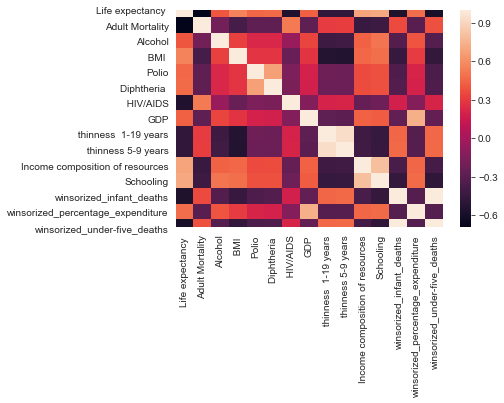

In [22]:
sns.heatmap(life_exp_df[vars].corr())
plt.show()

From the chart above, we can see that there is a very strong correlation between thinness 1-19 years and thinness 5-9 years, so we do not want to include both of those variables. I will eliminate thinness 5-9 years.

Now, I will visualize the relationships between life expectancy and the remaining variables.

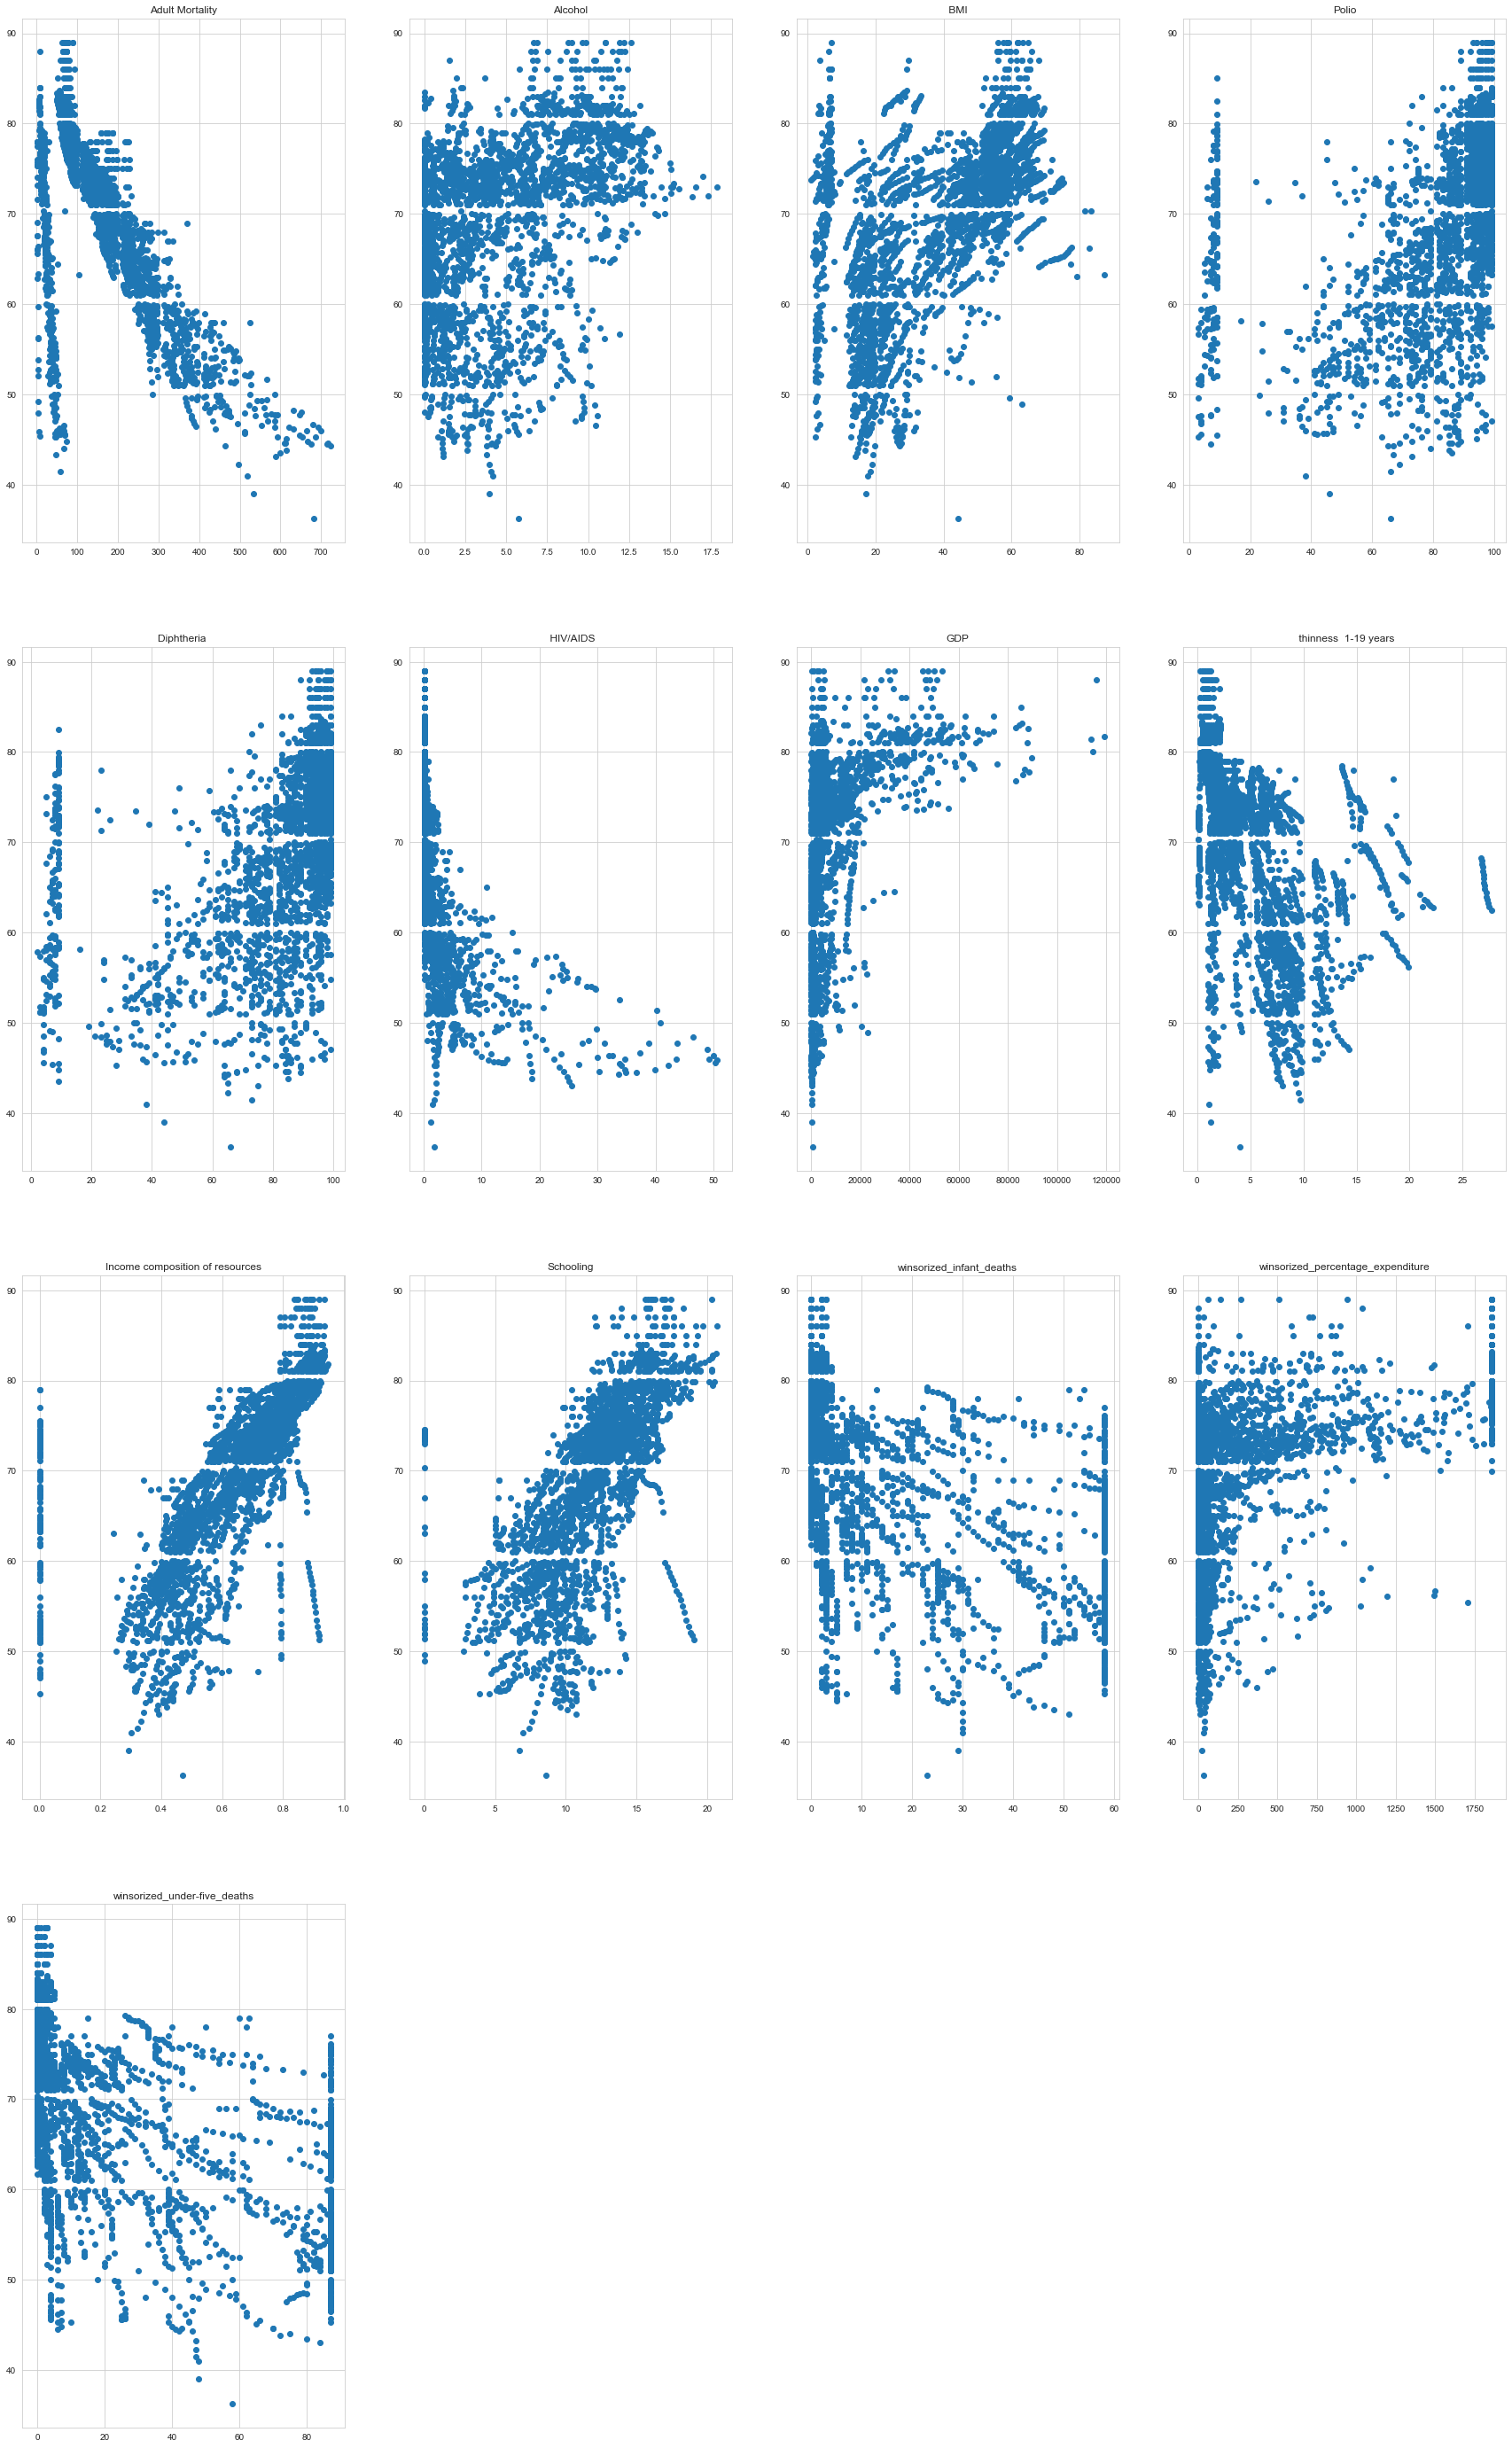

In [23]:
vars2 = ['Adult Mortality', 'Alcohol', ' BMI ', 'Polio',
       'Diphtheria ', ' HIV/AIDS', 'GDP', ' thinness  1-19 years', 
        'Income composition of resources', 'Schooling', 'winsorized_infant_deaths', 'winsorized_percentage_expenditure',
       'winsorized_under-five_deaths']
plt.figure(figsize=(30,50))
for index, var in enumerate(vars2):
    plt.subplot(4, 4, index+1)
    plt.scatter(life_exp_df[var], life_exp_df['Life expectancy '])
    plt.title(var)
    plt.xlabel('')

plt.show()

From the chart above, it is clear that schooling and income composition of resources have the strongest correlation with life expectancy; however, the other factors could still be useful to include in a model. 